In [1]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
import scipy as scp
import pandas as pd
import copy as cp
from tqdm import tqdm
import scipy.stats as stats

import pymc3 as pm
import arviz as az
sns.set_theme(style="white", context='talk', font_scale=1.5, font="Helvetica")
%matplotlib inline

RANDOM_SEED = 8927

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w 

Last updated: Mon Mar 13 2023

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 8.10.0

numpy     : 1.22.3
pymc3     : 3.11.4
matplotlib: 3.7.0
arviz     : 0.11.2
scipy     : 1.7.1
pandas    : 1.5.3
seaborn   : 0.12.2

Watermark: 2.3.1



## Byesian model for mouth-form plasticity

In [4]:
MF_ratio = pd.read_csv('./MF_ratios.csv', sep=',', index_col=0)

In [5]:
MF_ratio.head()

,Strain,Culture,Eu,Total,Replicate
0,RSC019,OP50,33,50,1
1,RSC019,OP50,30,50,2
2,RSC019,OP50,23,50,3
3,RSC017,OP50,1,50,1
4,RSC017,OP50,5,50,2


In [6]:
def calculate_stat(diet, strain, dataset):
    G_samples = list(dataset[(dataset['Culture']==diet) & (dataset['Strain']==strain)]['Eu'])
    N_samples = list(dataset[(dataset['Culture']==diet) & (dataset['Strain']==strain)]['Total'])
    group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
    data = []
    for i in range(0, len(N_samples)):
        data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))
    with pm.Model() as model:
        μ = pm.Beta('μ', 1., 1.)
        κ = pm.HalfNormal('κ', 10)
        θ = pm.Beta('θ', alpha=μ*κ, beta=(1.0-μ)*κ, shape=len(N_samples))
        y = pm.Bernoulli('y', p=θ[group_idx], observed=data)
        trace = pm.sample(tune=5000, draws=10000, target_accept=0.95, random_seed=RANDOM_SEED, return_inferencedata=True)
        az.plot_trace(trace)
        stat_result = az.summary(trace, round_to=2, hdi_prob=0.95)
    return stat_result, trace

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, κ, μ]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 29 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, κ, μ]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 26 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, κ, μ]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 26 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, κ, μ]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 28 seconds.


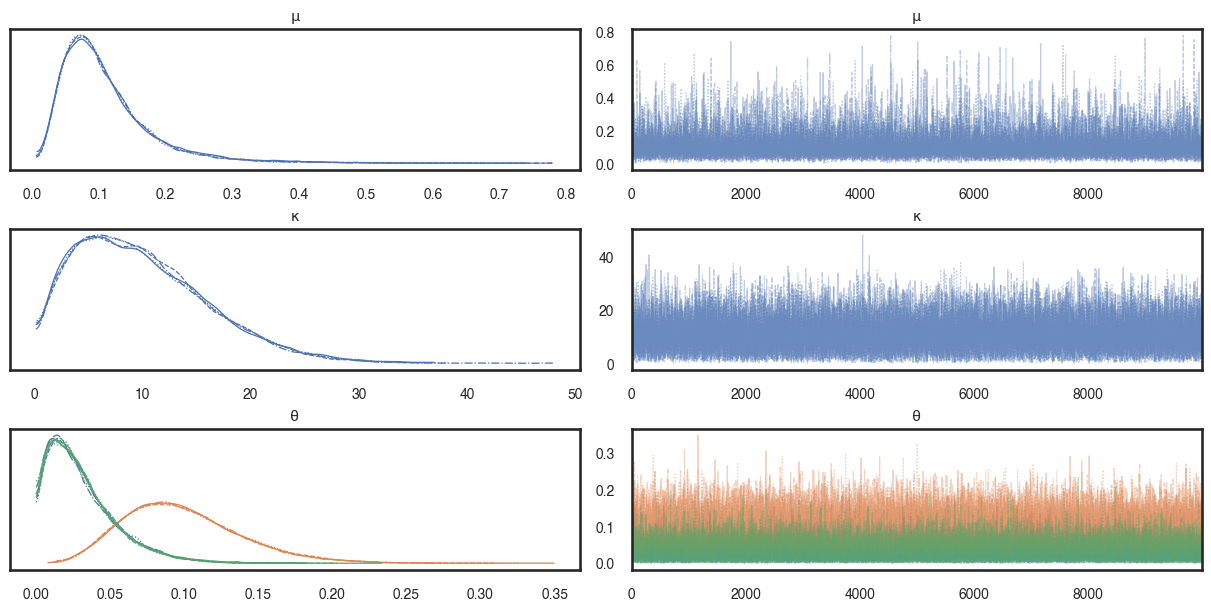

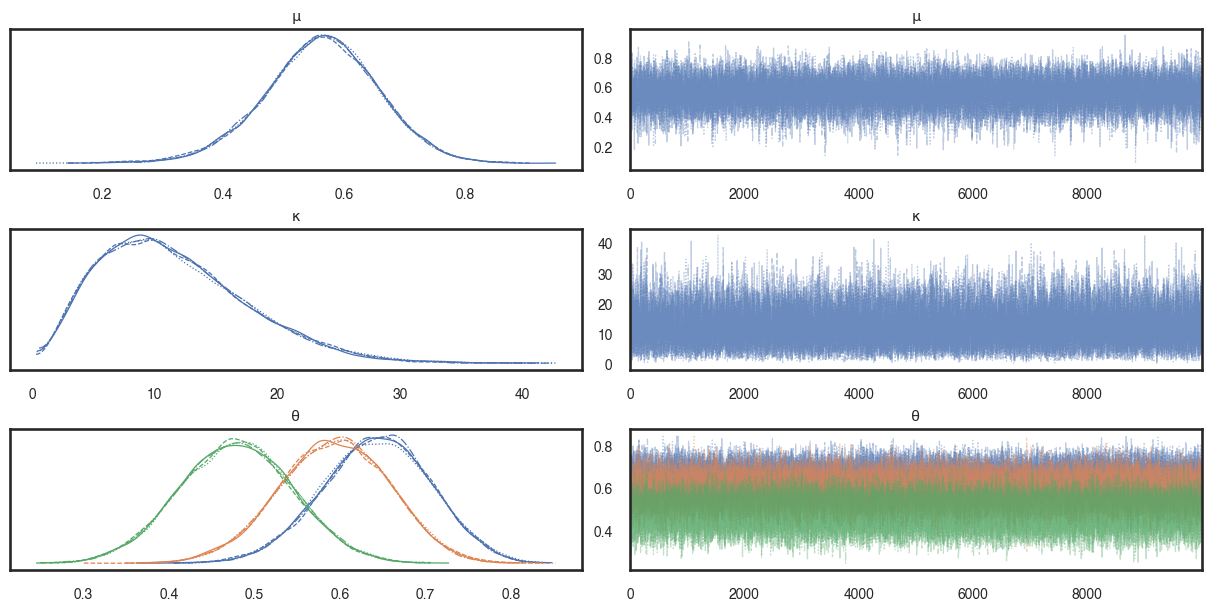

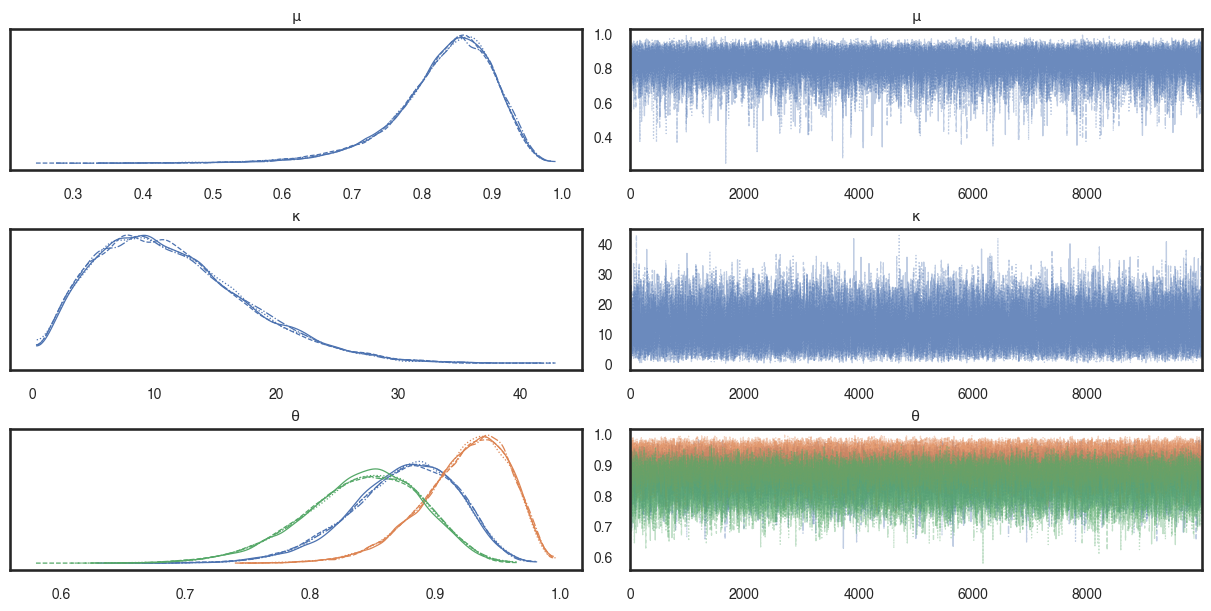

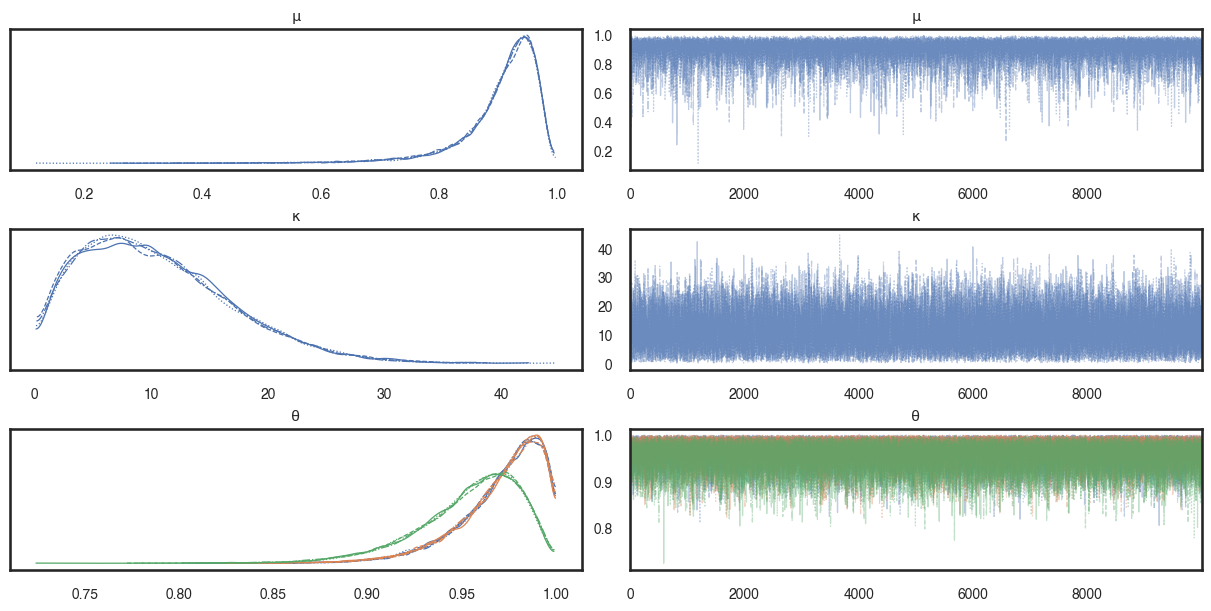

In [7]:
data = {}
for i in ['OP50', 'Novo']:
    for j in ['RSC017', 'RSC019']:
        data[i + '_' + j] = calculate_stat(i, j, MF_ratio)

Text(0.5, 0, '$\\sf \\lambda$ (Strain B)')

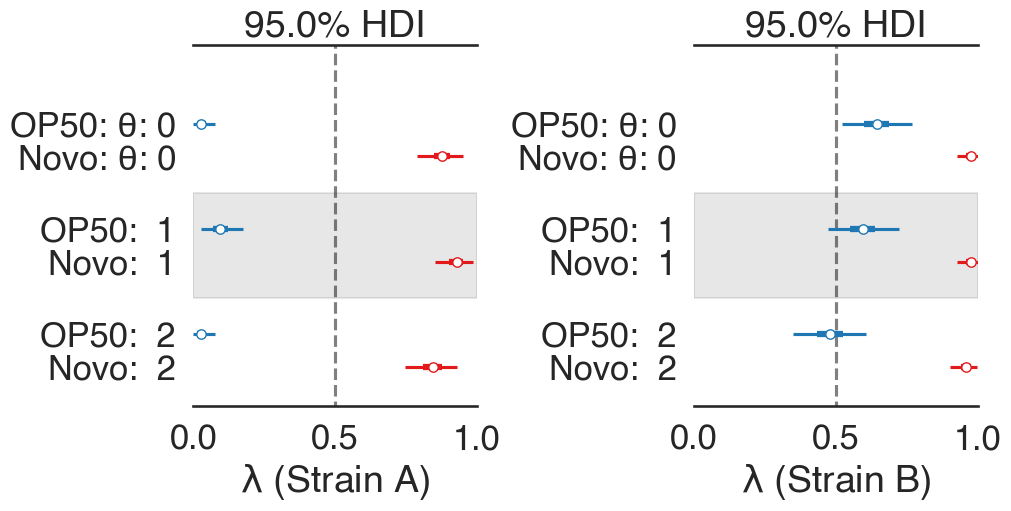

In [14]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10, 5),constrained_layout=True)

axes = axes.flatten()

az.plot_forest([data['OP50_RSC017'][1], data['Novo_RSC017'][1]], var_names='θ', combined=True, model_names=['OP50', 'Novo'], hdi_prob=0.95, colors=[sns.color_palette("Paired")[1], sns.color_palette("Paired")[5]], ax=axes[0])

axes[0].set_xlim(0, 1)

axes[0].vlines(0.5, -5, 10, linestyle='dashed', color='gray', zorder=0)

axes[0].set_xlabel(r'$\sf \lambda$ (Strain A)')

az.plot_forest([data['OP50_RSC019'][1], data['Novo_RSC019'][1]], var_names='θ', combined=True, model_names=['OP50', 'Novo'], hdi_prob=0.95, colors=[sns.color_palette("Paired")[1], sns.color_palette("Paired")[5]], ax=axes[1])

axes[1].set_xlim(0, 1)

axes[1].vlines(0.5, -5, 10, linestyle='dashed', color='gray', zorder=0)

axes[1].set_xlabel(r'$\sf \lambda$ (Strain B)')

## Bayesian model for daily fecundity data

In [15]:
fec_data = pd.read_csv('./comb_fec_data.csv', sep=',', index_col=0)

In [16]:
fec_data.head()

,index,Worm ID,Strain,Day,Progeny Count,Diet
0,0,1,RSC017,Day 1,27,OP50
1,1,2,RSC017,Day 1,24,OP50
2,2,3,RSC017,Day 1,26,OP50
3,3,4,RSC017,Day 1,7,OP50
4,4,5,RSC017,Day 1,23,OP50


- Strain A (OP50)

In [17]:
strain = fec_data[(fec_data['Strain']=='RSC017') & (fec_data['Diet']=='OP50')]
strain = strain.reset_index()
strain = strain.drop(columns=['index'])

egg_count = strain['Progeny Count'].values
days_idx = pd.Categorical(strain['Day'], categories=['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5']).codes
days = np.arange(0, len(np.unique(days_idx)), 1)

COORDS = {
    'obs': strain.index,
    'days': days
}
    
with pm.Model(coords=COORDS) as ZINB_model:
    # priors:
    ψ = pm.Beta("ψ", 1, 1, dims='days')
    λ = pm.Exponential("λ", 0.1, dims='days')
    α = pm.Exponential("α", 0.1, dims='days')
    # Likehood function
    likelihood = pm.ZeroInflatedNegativeBinomial("likelihood", psi=ψ[days_idx], mu=λ[days_idx], alpha=α[days_idx], observed=egg_count, dims='obs')    
    fec_trace = pm.sample(tune=1000, draws=4000, return_inferencedata=True, target_accept=0.95, random_seed=RANDOM_SEED)
    posterior_predictive = az.from_pymc3(posterior_predictive=pm.sample_posterior_predictive(trace=fec_trace, random_seed=RANDOM_SEED))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, λ, ψ]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 25 seconds.


0, dim: obs, 250 =? 250


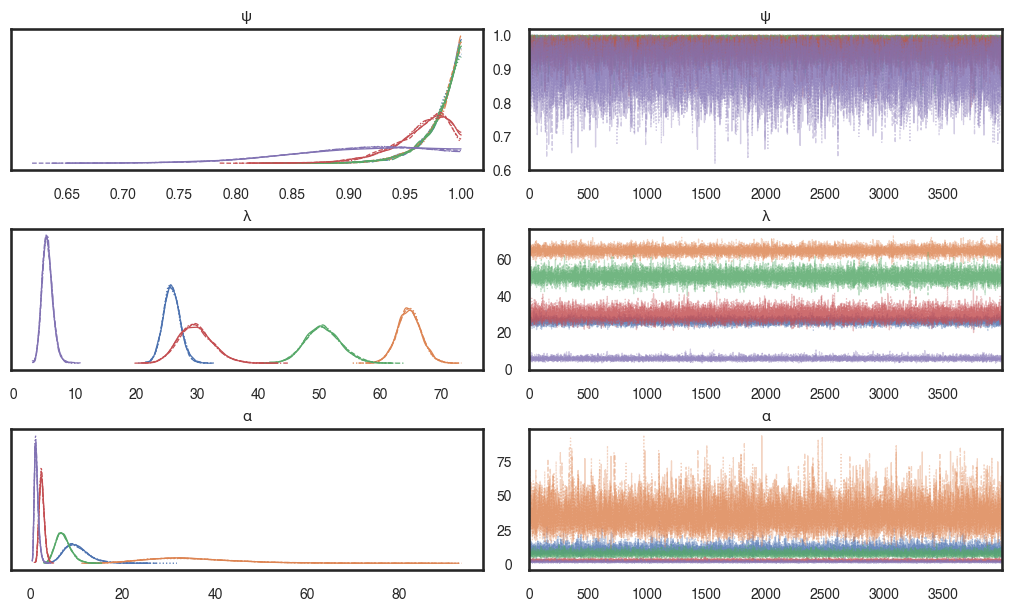

In [21]:
az.plot_trace(fec_trace, figsize=(10,6));

- Strain (Novo)

In [22]:
strain = fec_data[(fec_data['Strain']=='RSC017') & (fec_data['Diet']=='Novo')]
strain = strain.reset_index()
strain = strain.drop(columns=['index'])

egg_count = strain['Progeny Count'].values
days_idx = pd.Categorical(strain['Day'], categories=['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5']).codes
days = np.arange(0, len(np.unique(days_idx)), 1)

COORDS = {
    'obs': strain.index,
    'days': days
}
    
with pm.Model(coords=COORDS) as ZINB_model:
    # priors:
    ψ = pm.Beta("ψ", 1, 1, dims='days')
    λ = pm.Exponential("λ", 0.1, dims='days')
    α = pm.Exponential("α", 0.1, dims='days')
    # Likehood function
    likelihood = pm.ZeroInflatedNegativeBinomial("likelihood", psi=ψ[days_idx], mu=λ[days_idx], alpha=α[days_idx], observed=egg_count, dims='obs')    
    fec_trace = pm.sample(tune=1000, draws=4000, return_inferencedata=True, target_accept=0.95, random_seed=RANDOM_SEED)
    posterior_predictive = az.from_pymc3(posterior_predictive=pm.sample_posterior_predictive(trace=fec_trace, random_seed=RANDOM_SEED))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, λ, ψ]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 24 seconds.


0, dim: obs, 235 =? 235


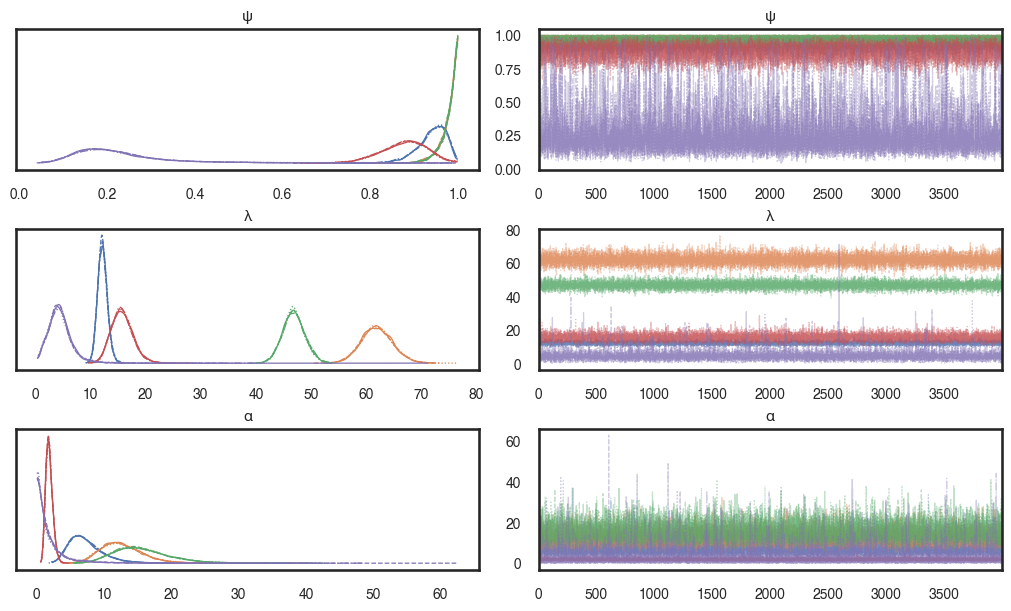

In [23]:
az.plot_trace(fec_trace, figsize=(10,6));

- Strain B (OP50)

In [24]:
strain = fec_data[(fec_data['Strain']=='RSC019') & (fec_data['Diet']=='OP50')]
strain = strain.reset_index()
strain = strain.drop(columns=['index'])

egg_count = strain['Progeny Count'].values
days_idx = pd.Categorical(strain['Day'], categories=['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5']).codes
days = np.arange(0, len(np.unique(days_idx)), 1)

COORDS = {
    'obs': strain.index,
    'days': days
}
    
with pm.Model(coords=COORDS) as ZINB_model:
    # priors:
    ψ = pm.Beta("ψ", 1, 1, dims='days')
    λ = pm.Exponential("λ", 0.1, dims='days')
    α = pm.Exponential("α", 0.1, dims='days')
    # Likehood function
    likelihood = pm.ZeroInflatedNegativeBinomial("likelihood", psi=ψ[days_idx], mu=λ[days_idx], alpha=α[days_idx], observed=egg_count, dims='obs')    
    fec_trace = pm.sample(tune=1000, draws=4000, return_inferencedata=True, target_accept=0.95, random_seed=RANDOM_SEED)
    #posterior_predictive = az.from_pymc3(posterior_predictive=pm.sample_posterior_predictive(trace=fec_trace, random_seed=RANDOM_SEED))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, λ, ψ]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 31 seconds.


0, dim: obs, 550 =? 550


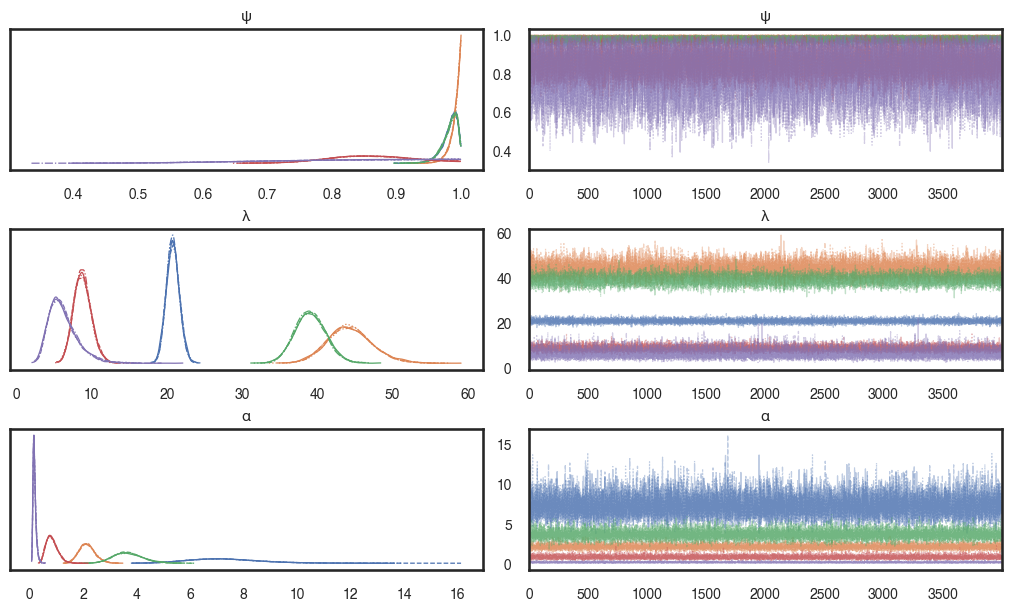

In [25]:
az.plot_trace(fec_trace, figsize=(10,6));

- Strain B (Novo)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, λ, ψ]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 26 seconds.


0, dim: obs, 225 =? 225


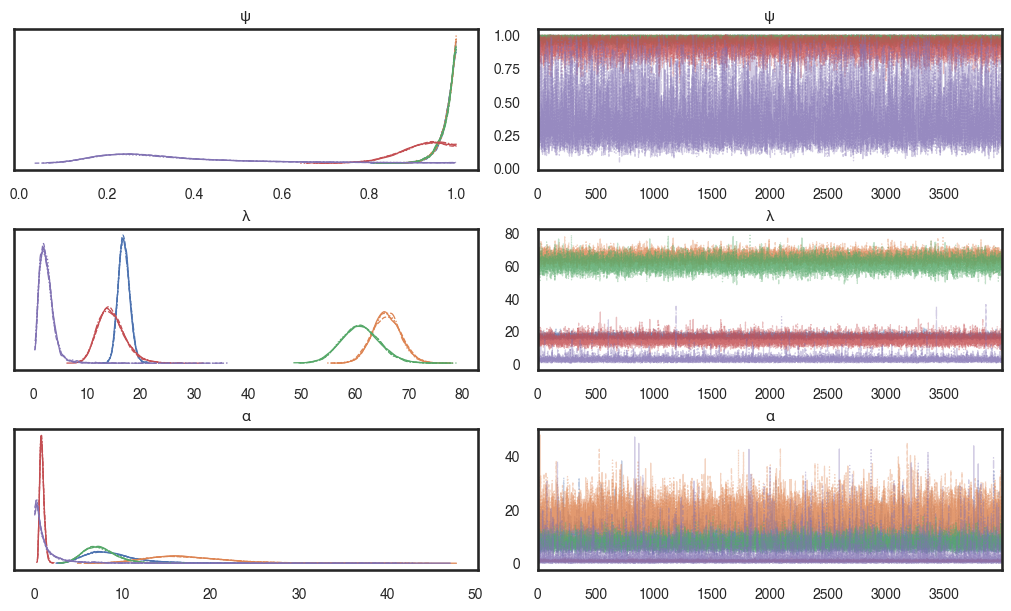

In [26]:
strain = fec_data[(fec_data['Strain']=='RSC019') & (fec_data['Diet']=='Novo')]
strain = strain.reset_index()
strain = strain.drop(columns=['index'])

egg_count = strain['Progeny Count'].values
days_idx = pd.Categorical(strain['Day'], categories=['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5']).codes
days = np.arange(0, len(np.unique(days_idx)), 1)

COORDS = {
    'obs': strain.index,
    'days': days
}
    
with pm.Model(coords=COORDS) as ZINB_model:
    # priors:
    ψ = pm.Beta("ψ", 1, 1, dims='days')
    λ = pm.Exponential("λ", 0.1, dims='days')
    α = pm.Exponential("α", 0.1, dims='days')
    # Likehood function
    likelihood = pm.ZeroInflatedNegativeBinomial("likelihood", psi=ψ[days_idx], mu=λ[days_idx], alpha=α[days_idx], observed=egg_count, dims='obs')    
    fec_trace = pm.sample(tune=1000, draws=4000, return_inferencedata=True, target_accept=0.95, random_seed=RANDOM_SEED)
    posterior_predictive = az.from_pymc3(posterior_predictive=pm.sample_posterior_predictive(trace=fec_trace, random_seed=RANDOM_SEED))
    
az.plot_trace(fec_trace, figsize=(10,6));

- Strain C (OP50)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, λ, ψ]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 25 seconds.


0, dim: obs, 250 =? 250


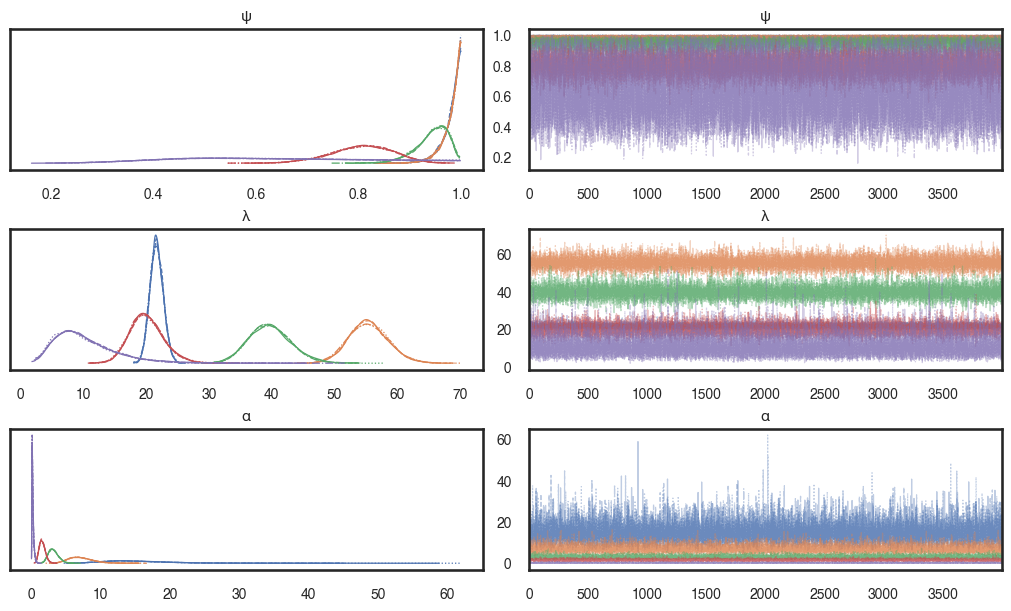

In [27]:
strain = fec_data[(fec_data['Strain']=='RS5405') & (fec_data['Diet']=='OP50')]
strain = strain.reset_index()
strain = strain.drop(columns=['index'])

egg_count = strain['Progeny Count'].values
days_idx = pd.Categorical(strain['Day'], categories=['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5']).codes
days = np.arange(0, len(np.unique(days_idx)), 1)

COORDS = {
    'obs': strain.index,
    'days': days
}
    
with pm.Model(coords=COORDS) as ZINB_model:
    # priors:
    ψ = pm.Beta("ψ", 1, 1, dims='days')
    λ = pm.Exponential("λ", 0.1, dims='days')
    α = pm.Exponential("α", 0.1, dims='days')
    # Likehood function
    likelihood = pm.ZeroInflatedNegativeBinomial("likelihood", psi=ψ[days_idx], mu=λ[days_idx], alpha=α[days_idx], observed=egg_count, dims='obs')    
    fec_trace = pm.sample(tune=1000, draws=4000, return_inferencedata=True, target_accept=0.95, random_seed=RANDOM_SEED)
    #posterior_predictive = az.from_pymc3(posterior_predictive=pm.sample_posterior_predictive(trace=fec_trace, random_seed=RANDOM_SEED))
    
az.plot_trace(fec_trace, figsize=(10,6));

- Strain C (Novo)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, λ, ψ]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 25 seconds.


0, dim: obs, 215 =? 215


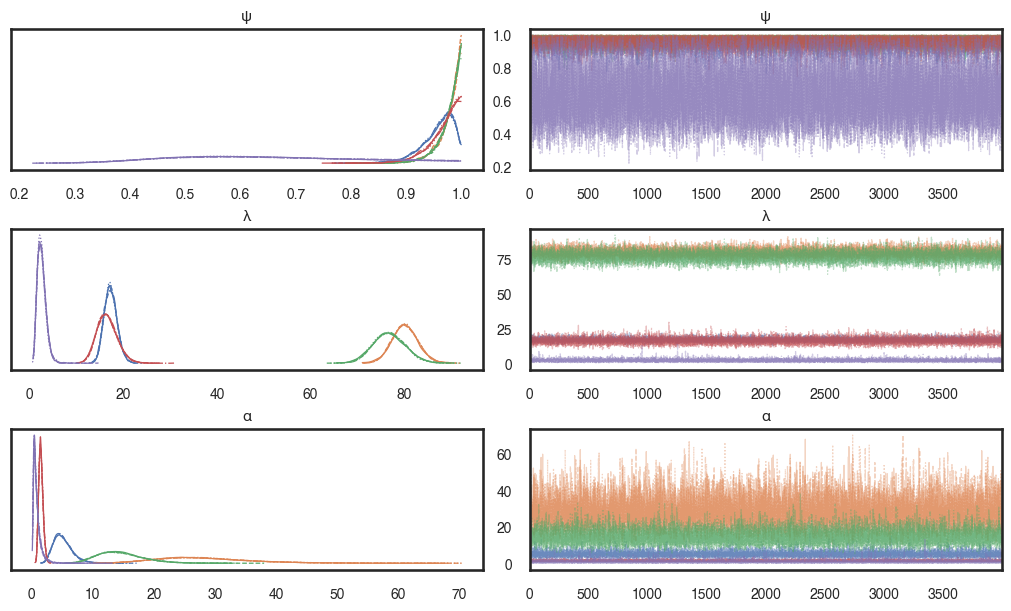

In [28]:
strain = fec_data[(fec_data['Strain']=='RS5405') & (fec_data['Diet']=='Novo')]
strain = strain.reset_index()
strain = strain.drop(columns=['index'])

egg_count = strain['Progeny Count'].values
days_idx = pd.Categorical(strain['Day'], categories=['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5']).codes
days = np.arange(0, len(np.unique(days_idx)), 1)

COORDS = {
    'obs': strain.index,
    'days': days
}
    
with pm.Model(coords=COORDS) as ZINB_model:
    # priors:
    ψ = pm.Beta("ψ", 1, 1, dims='days')
    λ = pm.Exponential("λ", 0.1, dims='days')
    α = pm.Exponential("α", 0.1, dims='days')
    # Likehood function
    likelihood = pm.ZeroInflatedNegativeBinomial("likelihood", psi=ψ[days_idx], mu=λ[days_idx], alpha=α[days_idx], observed=egg_count, dims='obs')    
    fec_trace = pm.sample(tune=1000, draws=4000, return_inferencedata=True, target_accept=0.95, random_seed=RANDOM_SEED)
    #posterior_predictive = az.from_pymc3(posterior_predictive=pm.sample_posterior_predictive(trace=fec_trace, random_seed=RANDOM_SEED))
    
az.plot_trace(fec_trace, figsize=(10,6));